In [2]:
import yfinance as yf
import numpy as np
import ta
import pandas as pd  

def get_stock_data(ticker_symbol, period='20y', interval='1d'):
    # Fetch data for the last 20 years
    data = yf.download(ticker_symbol, period=period, interval=interval)
    columns = ['Open', 'High', 'Low', 'Close', 'Volume']
    predict_data = data[columns].copy()
    predict_data.reset_index(drop=True, inplace=True)

    predict_data.columns = ['open', 'high', 'low', 'close', 'volume']
    df = predict_data

    # Existing indicators
    df['OBV'] = ta.volume.on_balance_volume(df['close'], df['volume'])
    df['macd_DIF'] = ta.trend.macd_diff(df['close'])
    df['macd_SIGNAL'] = ta.trend.macd_signal(df['close'])
    df['macd_HIST'] = ta.trend.macd_diff(df['close'])
    df['EMA5'] = ta.trend.ema_indicator(df['close'], window=5)
    df['EMA10'] = ta.trend.ema_indicator(df['close'], window=10)
    df['EMA25'] = ta.trend.ema_indicator(df['close'], window=25)
    df['rsi_14'] = ta.momentum.rsi(df['close'], window=14)
    df['rsi_9'] = ta.momentum.rsi(df['close'], window=9)
    df['ATR'] = ta.volatility.average_true_range(df['high'], df['low'], df['close'], window=14)

    # New technical indicators (10+ additional features)
    # 1. Stochastic Oscillator
    stochastic = ta.momentum.StochasticOscillator(high=df['high'], low=df['low'], close=df['close'], window=14, smooth_window=3)
    df['stoch_%K'] = stochastic.stoch()
    df['stoch_%D'] = stochastic.stoch_signal()
    
    # 2. Bollinger Bands
    bb = ta.volatility.BollingerBands(close=df['close'], window=20, window_dev=2)
    df['bb_%b'] = bb.bollinger_pband()  # %B indicator
    df['bb_width'] = bb.bollinger_wband()  # Bandwidth
    
    # 3. ADX (Average Directional Movement Index)
    adx_ind = ta.trend.ADXIndicator(high=df['high'], low=df['low'], close=df['close'], window=14)
    df['ADX'] = adx_ind.adx()
    df['DMP'] = adx_ind.adx_pos()  # +DI
    df['DMN'] = adx_ind.adx_neg()  # -DI
    
    # 4. Commodity Channel Index (CCI)
    df['CCI'] = ta.trend.cci(high=df['high'], low=df['low'], close=df['close'], window=20)
    
    # 5. Williams %R
    df['williams_%R'] = ta.momentum.williams_r(high=df['high'], low=df['low'], close=df['close'], lbp=14)
    
    # 6. Chaikin Money Flow (CMF)
    df['CMF'] = ta.volume.chaikin_money_flow(high=df['high'], low=df['low'], close=df['close'], volume=df['volume'], window=20)
    
    # 7. Money Flow Index (MFI)
    df['MFI'] = ta.volume.money_flow_index(high=df['high'], low=df['low'], close=df['close'], volume=df['volume'], window=14)
    
    # 8. Rate of Change (ROC)
    df['ROC'] = ta.momentum.roc(close=df['close'], window=14)
    
    # 9. Parabolic SAR
    df['PSAR'] = ta.trend.psar_up(df['high'], df['low'], df['close'])
    
    # 10. TRIX (Triple Exponential Average)
    df['TRIX'] = ta.trend.trix(close=df['close'], window=15)
    
    # 11. Keltner Channels
    keltner = ta.volatility.KeltnerChannel(high=df['high'], low=df['low'], close=df['close'], window=20, window_atr=10)
    df['keltner_ma'] = keltner.keltner_channel_mband()
    df['keltner_upper'] = keltner.keltner_channel_hband()
    df['keltner_lower'] = keltner.keltner_channel_lband()
    
    # 12. Volume Weighted Average Price (VWAP)
    df['VWAP'] = ta.volume.volume_weighted_average_price(high=df['high'], low=df['low'], close=df['close'], volume=df['volume'], window=20)
    
    # 13. Donchian Channels
    donchian = ta.volatility.DonchianChannel(high=df['high'], low=df['low'], close=df['close'], window=20)
    df['donchian_upper'] = donchian.donchian_channel_hband()
    df['donchian_lower'] = donchian.donchian_channel_lband()
    
    # 14. Standard Deviation
    df['std_dev'] = df['close'].rolling(window=20).std()
    
    # 15. Volume Change Percentage
    df['volume_chg'] = df['volume'].pct_change(periods=5)

    # Return training data starting from index 50 to ensure all indicators have values
    training_data = df.loc[50:]
    return training_data



### Correlation Matrix

[*********************100%%**********************]  1 of 1 completed


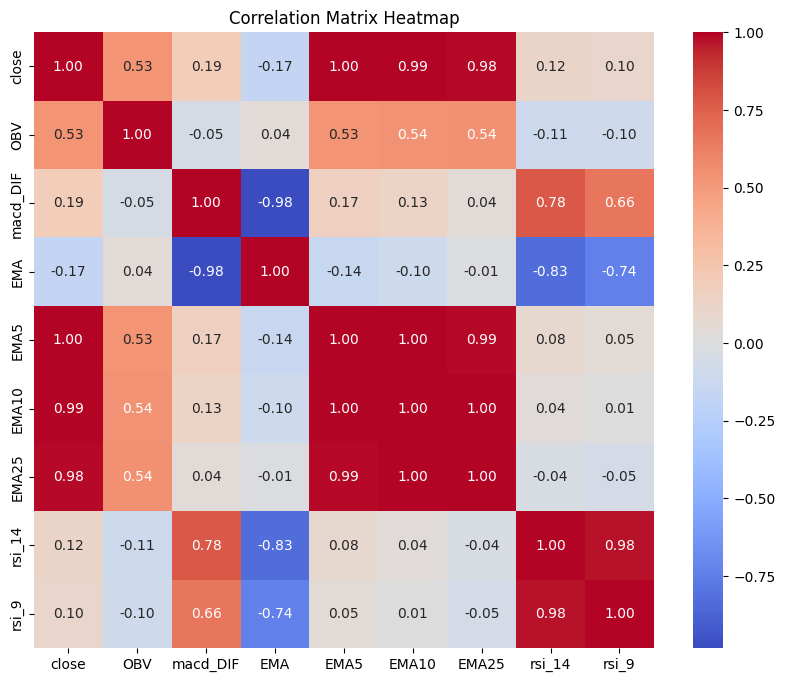

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

def calculate_correlation(training_data):
    indicators = training_data

    # Calculate the correlation matrix
    correlation_matrix = indicators.corr()
    # Return the correlation matrix
    return correlation_matrix

HANG_SENG_INDEX="^HSI"
training_data = get_stock_data(HANG_SENG_INDEX)

# Get the correlation matrix
training_data = training_data.drop(columns=['open', 'high', 'low', 'volume'])  # Features
correlation_matrix = calculate_correlation(training_data)


# Visualize the correlation matrix
def plot_correlation_heatmap(correlation_matrix):
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
    plt.title("Correlation Matrix Heatmap")
    plt.show()

# Example usage
plot_correlation_heatmap(correlation_matrix)

### RandomForestRegressor

In [6]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import numpy as np

HANG_SENG_INDEX="^HSI"
training_data = get_stock_data(HANG_SENG_INDEX)
# Assuming `training_data` is your DataFrame with features and target
X = training_data.drop(columns=['open', 'high', 'low', 'close', 'volume'])  # Features
y = training_data['close']  # Target

# Time-based split for time series data
split_index = int(len(training_data) * 0.8)
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

# Train a Random Forest model
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Get feature importances
importances = rf.feature_importances_
importances = importances / np.sum(importances)  # Normalize importances
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")
for f in range(X.shape[1]):
    print(f"{f + 1}. feature {X.columns[indices[f]]} ({importances[indices[f]]})")

# Select top N features
N = 5  # Number of top features to select
top_features = X.columns[indices[:N]]

# Use these top features for your CNN + BiLSTM model
X_train_selected = X_train[top_features]
X_test_selected = X_test[top_features]

# Now you can use X_train_selected and X_test_selected as inputs to your CNN + BiLSTM model

[*********************100%%**********************]  1 of 1 completed


Feature ranking:
1. feature EMA5 (0.9959449093403623)
2. feature rsi_9 (0.0020553391372070983)
3. feature rsi_14 (0.0005987971202292119)
4. feature OBV (0.0004404672663962972)
5. feature EMA10 (0.00026713895963619976)
6. feature macd_DIF (0.0002529957890608337)
7. feature EMA25 (0.00025149687862387947)
8. feature EMA (0.00018885550848417486)


In [8]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

# Assuming `training_data` is your DataFrame with features and target
X = training_data.drop(columns=['open', 'high', 'low', 'close', 'volume'])  # Features
y = training_data['close']  # Target

# Time-based split for time series data
split_index = int(len(training_data) * 0.8)
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

# Initialize the LinearRegression model
lr = LinearRegression()

# Initialize RFE with the LinearRegression model and the number of features to select
n_features_to_select = 5  # Number of top features to select
rfe = RFE(estimator=lr, n_features_to_select=n_features_to_select)

# Fit RFE
rfe.fit(X_train, y_train)

# Get the ranking of features
ranking = rfe.ranking_

# Print the feature ranking
print("Feature ranking:")
for i in range(X.shape[1]):
    print(f"{i + 1}. feature {X.columns[i]} (rank: {ranking[i]})")

# Select the top features
X_train_selected = X_train.loc[:, rfe.support_]
X_test_selected = X_test.loc[:, rfe.support_]

# Now you can use X_train_selected and X_test_selected as inputs to your CNN + BiLSTM model

Feature ranking:
1. feature OBV (rank: 4)
2. feature macd_DIF (rank: 1)
3. feature EMA (rank: 2)
4. feature EMA5 (rank: 3)
5. feature EMA10 (rank: 1)
6. feature EMA25 (rank: 1)
7. feature rsi_14 (rank: 1)
8. feature rsi_9 (rank: 1)
